<a href="https://colab.research.google.com/github/plaban1981/Haystack_NLP/blob/main/Haystack_for_Neural_Question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is Haystack for Neural Question Answering ?

* Haystack is a python framework for developing End to End question answering systems. 

* It is available both as an open source library and extended paid version.

* It provides a flexible way to use the latest NLP models to solve several QA tasks in real-world settings with huge data collections. 

* Haystack is useful for providing solutions to diverse QA tasks such as Financial Governance, Knowledge Base Search, Competitive intelligence etc.

## Core Idea behind HayStack Library

* Large Neural networks, especially ones with transformer-based architectures, perform extremely well not only on Extractive Question Answering but also on Generative Question Answering(QA). 

* But these models are computationally expensive and time-consuming. This makes them unusable in latency-sensitive applications. 

* HayStack solves this problem by prefiltering the documents using faster but less powerful solutions. This allows the Neural Model to complete inference in a small amount of time.

## Typical Haystack Pipeline


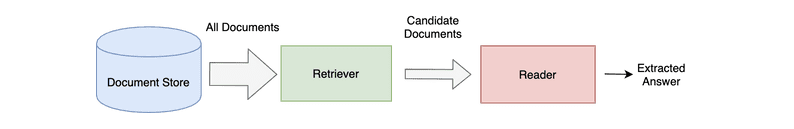

## Retriever

* **Retriever** is a lightweight filter that scans through all the documents in the Document store and identifies a small relevant candidate set of documents.

* **Retrievers** can be models using both sparse or dense methods.One very efficient retriever model is **ElasticSearch**.It is a proper sparse indexing based search engine.


## Reader

* The reader is a powerful model that closely examines each document and finds the answer to the question. 

* Using the latest models like the transformer models gives the Reader the capability to semantically extract information from documents instead of plain lexical search. 

* Reader models are generally built by adding a Question Answering Head on Language Models like BERT.

* To Do this, Deepset provides a framework called **FARM: Framework for Adapting Representation Models**. 
* This framework facilitates transfer learning on representation models.

## Setup
Install haystack and dependencies using pip

In [1]:
!pip install farm-haystack

     |████████████████████████████████| 180 kB 5.3 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 85 kB 4.4 MB/s 
     |████████████████████████████████| 3.4 MB 47.0 MB/s 
     |████████████████████████████████| 981 kB 69.8 MB/s 
     |████████████████████████████████| 8.4 MB 61.6 MB/s 
     |████████████████████████████████| 52 kB 622 kB/s 
     |████████████████████████████████| 3.8 MB 38.8 MB/s 
     |████████████████████████████████| 50 kB 4.0 MB/s 
     |████████████████████████████████| 57 kB 4.1 MB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 330 kB 41.9 MB/s 
     |████████████████████████████████| 204 kB 69.9 MB/s 
     |████████████████████████████████| 402 kB 66.2 MB/s 
     |████████████████████████████████| 5.6 MB 53.0 MB/s 
     |████████████████████████████████| 100 kB 10.3 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |███████████████████████

In [2]:
 !pip install urllib3==1.25.4

     |████████████████████████████████| 125 kB 5.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Start an Elasticsearch server

* We can start Elasticsearch on your local machine instance using Docker. 

* If Docker is not readily available in your environment (eg., in Colab notebooks), then you can manually download and execute Elasticsearch from source.

For the retriever model, we can use many models ranging from simple TFIDFReader to ElasticSearch.But here we are using Elasticsearch

In [3]:
 ! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
 ! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
 ! chown -R daemon:daemon elasticsearch-7.9.2
 import os
 from subprocess import Popen, PIPE, STDOUT
 es_server = Popen(['elasticsearch-7.9.2/bin/elasticsearch'],
                    stdout=PIPE, stderr=STDOUT,
                    preexec_fn=lambda: os.setuid(1)  # as daemon
                   )
 # wait until ES has started
 ! sleep 30 

## Import Haystack packages 

In [5]:
 from haystack import Finder
 from haystack.preprocessor.cleaning import clean_wiki_text
 from haystack.preprocessor.utils import convert_files_to_dicts, fetch_archive_from_http
 from haystack.reader.farm import FARMReader
 from haystack.reader.transformers import TransformersReader
 from haystack.utils import print_answers 

## Document Store

* Haystack finds answers to queries within the documents stored in a DocumentStore. 
* The current implementations of DocumentStore include : 
      * ElasticsearchDocumentStore, 
      * FAISSDocumentStore, 
      * SQLDocumentStore, and 
      * InMemoryDocumentStore.

* Here: We recommended Elasticsearch as it comes preloaded with features like full-text queries, BM25 retrieval, and vector storage for text embeddings.

* Alternatives: If you are unable to setup an Elasticsearch instance, then we can go for using SQL/InMemory document stores.

In [6]:
# Connect to Elasticsearch

from haystack.document_store.elasticsearch import ElasticsearchDocumentStore
document_store = ElasticsearchDocumentStore(host="localhost", username="", password="", index="document")

08/17/2021 11:04:02 - INFO - elasticsearch -   HEAD http://localhost:9200/ [status:200 request:0.114s]
08/17/2021 11:04:03 - INFO - elasticsearch -   PUT http://localhost:9200/document [status:200 request:0.503s]
08/17/2021 11:04:03 - INFO - elasticsearch -   PUT http://localhost:9200/label [status:200 request:0.276s]


## Loading the Data

Haystack provides a customizable pipeline for:

* converting files into texts
* cleaning texts
* splitting texts
* writing them to a Document Store

In [7]:
# Let's first get some documents that we want to query
# Here: 517 Wikipedia articles for Game of Thrones
doc_dir = "data/article_txt_got"
s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/wiki_gameofthrones_txt.zip"
fetch_archive_from_http(url=s3_url, output_dir=doc_dir)
# convert files to dicts containing documents that can be indexed to our datastore
# You can optionally supply a cleaning function that is applied to each doc (e.g. to remove footers)
# It must take a str as input, and return a str.
dicts = convert_files_to_dicts(dir_path=doc_dir, clean_func=clean_wiki_text, split_paragraphs=True)
# We now have a list of dictionaries that we can write to our document store.
# If your texts come from a different source (e.g. a DB), you can of course skip convert_files_to_dicts() and create the dictionaries yourself.
# The default format here is: {"name": "<some-document-name>, "text": "<the-actual-text>"}
# Let's have a look at the first 3 entries:
print(dicts[:3])
# Now, let's write the docs to our DB.
document_store.write_documents(dicts) 

08/17/2021 11:20:19 - INFO - haystack.preprocessor.utils -   Fetching from https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/wiki_gameofthrones_txt.zip to `data/article_txt_got`
100%|██████████| 1095120/1095120 [00:00<00:00, 1691110.64B/s]
08/17/2021 11:20:20 - INFO - haystack.preprocessor.utils -   Converting data/article_txt_got/218_Olenna_Tyrell.txt
08/17/2021 11:20:20 - INFO - haystack.preprocessor.utils -   Converting data/article_txt_got/368_Jaime_Lannister.txt
08/17/2021 11:20:20 - INFO - haystack.preprocessor.utils -   Converting data/article_txt_got/57_The_Laws_of_Gods_and_Men.txt
08/17/2021 11:20:20 - INFO - haystack.preprocessor.utils -   Converting data/article_txt_got/513_Oathbreaker__Game_of_Thrones_.txt
08/17/2021 11:20:20 - INFO - haystack.preprocessor.utils -   Converting data/article_txt_got/129_Second_Sons.txt
08/17/2021 11:20:20 - INFO - haystack.preprocessor.utils -   Converting data/article_txt_got/118_Dark_Wings__Dark_Words.txt
08/17/202

[{'text': "'''Olenna Tyrell''' is a fictional character in the ''A Song of Ice and Fire'' series of high fantasy novels by American author George R. R. Martin, and its television adaptation, ''Game of Thrones''.\nOlenna is first mentioned in ''A Game of Thrones'' (1996) and appears in ''A Storm of Swords'' (2000) and ''A Feast for Crows'' (2005). She is the matriarch of the powerful House Tyrell, the largest and second wealthiest of the eight Great Houses of Westeros. Olenna is characterized by her cunning, ambition, and sharp wit (the latter of which being the foundation for her title, '''the Queen of Thorns''', alongside the Tyrell sigil of a rose). Although her family is allied with the Lannisters in King's Landing, she often finds her own machinations at odds with theirs, especially those of Tywin Lannister. She, along with Petyr Baelish, is responsible for the death of King Joffrey Baratheon during his wedding to her granddaughter and protégé, Margaery.\nOlenna is portrayed by vet

08/17/2021 11:20:23 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.190s]
08/17/2021 11:20:24 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.149s]
08/17/2021 11:20:25 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.110s]
08/17/2021 11:20:26 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.078s]
08/17/2021 11:20:28 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.066s]


## Model Pipeline

Haystack provides a flexible way to build search pipelines. Each pipeline is a Directed Acyclic graph where each node is a reader/ retriever/ generator etc.





## Initalize Retriever, Reader, & Pipeline

#### Retriever
Retrievers help narrowing down the scope for the Reader to smaller units of text where a given question could be answered. They use some simple but fast algorithm.

Here: We use Elasticsearch's default BM25 algorithm

Alternatives:

* Customize the ElasticsearchRetrieverwith custom queries (e.g. boosting) and filters
* Use TfidfRetriever in combination with a SQL or * InMemory Document store for simple prototyping and debugging
* Use EmbeddingRetriever to find candidate documents based on the similarity of embeddings (e.g. created via Sentence-BERT)
* Use DensePassageRetriever to use different embedding models for passage and query (see Tutorial 6)


## Reader
* A Reader scans the texts returned by retrievers in detail and extracts the k best answers. They are based on powerful, but slower deep learning models.

* Haystack currently supports Readers based on the frameworks FARM and Transformers. 

* With both you can either load a local model or one from Hugging Face's model hub (https://huggingface.co/models).

* **FARM: Framework for Adapting Representation Models.**

In [8]:
from haystack.retriever.sparse import ElasticsearchRetriever
retriever = ElasticsearchRetriever(document_store=document_store)
reader = FARMReader(model_name_or_path="distilbert-base-uncased-distilled-squad", use_gpu=True)
 

08/17/2021 11:32:21 - INFO - farm.utils -   Using device: CPU 
08/17/2021 11:32:21 - INFO - farm.utils -   Number of GPUs: 0
08/17/2021 11:32:21 - INFO - farm.utils -   Distributed Training: False
08/17/2021 11:32:21 - INFO - farm.utils -   Automatic Mixed Precision: None
08/17/2021 11:32:22 - INFO - filelock -   Lock 139671858922064 acquired on /root/.cache/huggingface/transformers/ab70e5f489e00bb2df55e4bae145e9b1c7dc794cfa0fd8228e1299d400613429.f3874c2af5400915dc843c97f502c5d30edc728e5ec3b60c4bd6958e87970f75.lock


Downloading:   0%|          | 0.00/451 [00:00<?, ?B/s]

08/17/2021 11:32:22 - INFO - filelock -   Lock 139671858922064 released on /root/.cache/huggingface/transformers/ab70e5f489e00bb2df55e4bae145e9b1c7dc794cfa0fd8228e1299d400613429.f3874c2af5400915dc843c97f502c5d30edc728e5ec3b60c4bd6958e87970f75.lock
08/17/2021 11:32:22 - INFO - filelock -   Lock 139671858922064 acquired on /root/.cache/huggingface/transformers/b00ff18397f70f871bd8f11949a3c5ffd5fb18fd6d4e3df947dc386950b8d59d.69a963759b72d26fb77afa9b7d43c9107b99dfe7ca78af52e0237c8d001c7dcf.lock


Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

08/17/2021 11:32:30 - INFO - filelock -   Lock 139671858922064 released on /root/.cache/huggingface/transformers/b00ff18397f70f871bd8f11949a3c5ffd5fb18fd6d4e3df947dc386950b8d59d.69a963759b72d26fb77afa9b7d43c9107b99dfe7ca78af52e0237c8d001c7dcf.lock
Some weights of the model checkpoint at distilbert-base-uncased-distilled-squad were not used when initializing DistilBertModel: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
08/17/2021 11:32:34 - INFO - filelock -   Lock 139671828360144 acquired on /root/.cache/huggingface/transformers/03db

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

08/17/2021 11:32:34 - INFO - filelock -   Lock 139671828360144 released on /root/.cache/huggingface/transformers/03dbd2b11eae924dfd97070ed60502df863584957419a604e1c039e0eab3f974.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
08/17/2021 11:32:34 - INFO - filelock -   Lock 139671828397456 acquired on /root/.cache/huggingface/transformers/8785a0072d807ebc8a3b6bf5648744bfc3cc83e0e845c40b670d10c0d7827164.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

08/17/2021 11:32:34 - INFO - filelock -   Lock 139671828397456 released on /root/.cache/huggingface/transformers/8785a0072d807ebc8a3b6bf5648744bfc3cc83e0e845c40b670d10c0d7827164.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
08/17/2021 11:32:35 - INFO - filelock -   Lock 139671830449296 acquired on /root/.cache/huggingface/transformers/c0abea01d3725dc3c06370cced02822e09a715c98c62346f5ec9b730361df18d.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

08/17/2021 11:32:35 - INFO - filelock -   Lock 139671830449296 released on /root/.cache/huggingface/transformers/c0abea01d3725dc3c06370cced02822e09a715c98c62346f5ec9b730361df18d.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock
08/17/2021 11:32:35 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
08/17/2021 11:32:35 - INFO - farm.utils -   Using device: CPU 
08/17/2021 11:32:35 - INFO - farm.utils -   Number of GPUs: 0
08/17/2021 11:32:35 - INFO - farm.utils -   Distributed Training: False
08/17/2021 11:32:35 - INFO - farm.utils -   Automatic Mixed Precision: None
08/17/2021 11:32:35 - INFO - farm.infer -   Got ya 2 parallel workers to do inference ...
08/17/2021 11:32:35 - INFO - farm.infer -    0    0 
08/17/2021 11:32:35 - INFO - farm.infer -   /w\  /w\
08/17/2021 11:32:35 - INFO - farm.infer -   /'\  / \
08/17/2021 11:32:35 - INFO - farm.infer -     


* With a Haystack Pipeline you can stick together your building blocks to a search pipeline. 
* Under the hood, Pipelines are Directed Acyclic Graphs (DAGs) that you can easily customize for your own use cases. 
* To speed things up, Haystack also comes with a few predefined Pipelines. 
* One of them is the **ExtractiveQAPipeline** that combines a retriever and a reader to answer our questions. You can learn more about Pipelines in the docs.

In [9]:
from haystack.pipeline import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader, retriever)

## Inference

In [10]:
prediction = pipe.run(query="Who is the father of Joffrey?", top_k_retriever=10, top_k_reader=5)

08/17/2021 11:36:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.187s]
Inferencing Samples: 100%|██████████| 1/1 [00:02<00:00,  2.32s/ Batches]


In [11]:
print_answers(prediction, details="minimal")

[   {   'answer': 'Eddard',
        'context': 's Nymeria after a legendary warrior queen. She travels '
                   "with her father, Eddard, to King's Landing when he is made "
                   'Hand of the King. Before she leaves,'},
    {   'answer': 'King Robert Baratheon',
        'context': 'nerys and her dragons, but Tywin claims there is no '
                   'threat.\n'
                   'On Blackwater Bay, Melisandre reveals to Gendry that his '
                   'father was King Robert Baratheon.'},
    {   'answer': 'Lord Eddard Stark',
        'context': 'ark daughters.\n'
                   'During the Tourney of the Hand to honour her father Lord '
                   'Eddard Stark, Sansa Stark is enchanted by the knights '
                   'performing in the event.'},
    {   'answer': 'Robert Baratheon and Queen Cersei Lannister',
        'context': ' Joffrey is allegedly the oldest son and heir of King '
                   'Robert Baratheon and Queen Ce

## Dense Methods

* Although ElasticSearch is a decent and fast retriever based on BM25 algo, but it doesn’t compare in accuracy to dense methods.

* Dense methods are parameter-dependent and require training to learn these parameters.h

In [12]:
from haystack.retriever.dense import DensePassageRetriever
dense_retriever = DensePassageRetriever(
     document_store=document_store,
     query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
     passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base"
 )

08/17/2021 12:24:50 - INFO - filelock -   Lock 139671837781968 acquired on /root/.cache/huggingface/transformers/4ad08b5f983c1384baaf257d8edf51a7a3961fd8c75a1778ac604e3c0b564dd9.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

08/17/2021 12:24:51 - INFO - filelock -   Lock 139671837781968 released on /root/.cache/huggingface/transformers/4ad08b5f983c1384baaf257d8edf51a7a3961fd8c75a1778ac604e3c0b564dd9.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
08/17/2021 12:24:51 - INFO - filelock -   Lock 139671830401680 acquired on /root/.cache/huggingface/transformers/b305bc9085b3d0ce33551c251b75c11b6c6df1d4d51e5d3439d01cf4bb1abc9d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

08/17/2021 12:24:51 - INFO - filelock -   Lock 139671830401680 released on /root/.cache/huggingface/transformers/b305bc9085b3d0ce33551c251b75c11b6c6df1d4d51e5d3439d01cf4bb1abc9d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
08/17/2021 12:24:52 - INFO - filelock -   Lock 139671837778576 acquired on /root/.cache/huggingface/transformers/d5b5f07ee846d5baa7142e121b6ee77d11ac68bd5d4541faab38a1ea76c2954a.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

08/17/2021 12:24:52 - INFO - filelock -   Lock 139671837778576 released on /root/.cache/huggingface/transformers/d5b5f07ee846d5baa7142e121b6ee77d11ac68bd5d4541faab38a1ea76c2954a.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock
08/17/2021 12:24:52 - INFO - filelock -   Lock 139671837979664 acquired on /root/.cache/huggingface/transformers/52774638a790c9ebc5ce11005b260f79cd4cc389abdab9eaa31e8f09d15b4f46.13b559f49587470ab6d85a7dde13174670a0b61c1b942d1489c96023f5d03772.lock


Downloading:   0%|          | 0.00/493 [00:00<?, ?B/s]

08/17/2021 12:24:52 - INFO - filelock -   Lock 139671837979664 released on /root/.cache/huggingface/transformers/52774638a790c9ebc5ce11005b260f79cd4cc389abdab9eaa31e8f09d15b4f46.13b559f49587470ab6d85a7dde13174670a0b61c1b942d1489c96023f5d03772.lock
08/17/2021 12:24:53 - INFO - filelock -   Lock 139671830432400 acquired on /root/.cache/huggingface/transformers/41dac75f5df9070331cb0e4bf318c9fdeaef38d9ffd8ca80993c7db830d0c674.446ee898f4788c3ee90f8e7ee5a50281905f509e698f76dc0b583eb74ef973bd.lock


Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

08/17/2021 12:25:08 - INFO - filelock -   Lock 139671830432400 released on /root/.cache/huggingface/transformers/41dac75f5df9070331cb0e4bf318c9fdeaef38d9ffd8ca80993c7db830d0c674.446ee898f4788c3ee90f8e7ee5a50281905f509e698f76dc0b583eb74ef973bd.lock
08/17/2021 12:25:11 - INFO - filelock -   Lock 139671829940944 acquired on /root/.cache/huggingface/transformers/deacb2c219c1bfe83909173f286b60d7cbfd37fc73dc8de723805ca82cabd183.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

08/17/2021 12:25:11 - INFO - filelock -   Lock 139671829940944 released on /root/.cache/huggingface/transformers/deacb2c219c1bfe83909173f286b60d7cbfd37fc73dc8de723805ca82cabd183.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
08/17/2021 12:25:12 - INFO - filelock -   Lock 139671811163984 acquired on /root/.cache/huggingface/transformers/9a42d18175a45f8dcfd587d7056cbe397e0fe49828bcc543bc3f5b4d2862f7e5.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

08/17/2021 12:25:12 - INFO - filelock -   Lock 139671811163984 released on /root/.cache/huggingface/transformers/9a42d18175a45f8dcfd587d7056cbe397e0fe49828bcc543bc3f5b4d2862f7e5.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
08/17/2021 12:25:12 - INFO - filelock -   Lock 139671809700240 acquired on /root/.cache/huggingface/transformers/70b0d7ed89bb3511a323f99b7cfa4a3e0c35754fda6a3ac74c3458ca8ffb5764.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

08/17/2021 12:25:12 - INFO - filelock -   Lock 139671809700240 released on /root/.cache/huggingface/transformers/70b0d7ed89bb3511a323f99b7cfa4a3e0c35754fda6a3ac74c3458ca8ffb5764.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock
08/17/2021 12:25:13 - INFO - filelock -   Lock 139671809766160 acquired on /root/.cache/huggingface/transformers/f31ea67434695abc6c4fbe109214416d8b48a44f2fe5a0617e7faa3d6a4f8d05.be8dbf4cc0650b9c5997b3b3bc47d0d6c20749c3871e9285d3b624cd75dd9ee6.lock


Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

08/17/2021 12:25:13 - INFO - filelock -   Lock 139671809766160 released on /root/.cache/huggingface/transformers/f31ea67434695abc6c4fbe109214416d8b48a44f2fe5a0617e7faa3d6a4f8d05.be8dbf4cc0650b9c5997b3b3bc47d0d6c20749c3871e9285d3b624cd75dd9ee6.lock
08/17/2021 12:25:13 - INFO - filelock -   Lock 139671830061968 acquired on /root/.cache/huggingface/transformers/2623d56adfe8cc7bf9275b0c620a0e271ee4004c335173bde56310dc8ea99d4f.714228ba33c6248205269978fd6d0ca0ef96508cbd4a11d894882e71d45fad7c.lock


Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

08/17/2021 12:25:26 - INFO - filelock -   Lock 139671830061968 released on /root/.cache/huggingface/transformers/2623d56adfe8cc7bf9275b0c620a0e271ee4004c335173bde56310dc8ea99d4f.714228ba33c6248205269978fd6d0ca0ef96508cbd4a11d894882e71d45fad7c.lock


In [13]:
from haystack.pipeline import Pipeline,JoinDocuments
p = Pipeline()
p.add_node(component=retriever, name="ESRetriever", inputs=["Query"])
p.add_node(component=dense_retriever, name="DPRRetriever", inputs=["Query"])
p.add_node(component=JoinDocuments(join_mode="concatenate"), name="JoinResults", inputs=["ESRetriever", "DPRRetriever"])
p.add_node(component=reader, name="QAReader", inputs=["JoinResults"])

## Inference

In [14]:
prediction = pipe.run(query="Who is the father of Joffrey?", top_k_retriever=10, top_k_reader=5)
print(prediction)

08/17/2021 12:30:36 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.049s]
Inferencing Samples: 100%|██████████| 1/1 [00:02<00:00,  2.19s/ Batches]

{'query': 'Who is the father of Joffrey?', 'no_ans_gap': 21.32999873161316, 'answers': [{'answer': 'Eddard', 'score': 20.177249908447266, 'probability': 0.9989330172538757, 'context': "s Nymeria after a legendary warrior queen. She travels with her father, Eddard, to King's Landing when he is made Hand of the King. Before she leaves,", 'offset_start': 72, 'offset_end': 78, 'offset_start_in_doc': 147, 'offset_end_in_doc': 153, 'document_id': 'ba2a8e87ddd95e380bec55983ee7d55f', 'meta': {'name': '43_Arya_Stark.txt'}}, {'answer': 'King Robert Baratheon', 'score': 19.807899475097656, 'probability': 0.6502805352210999, 'context': 'nerys and her dragons, but Tywin claims there is no threat.\nOn Blackwater Bay, Melisandre reveals to Gendry that his father was King Robert Baratheon.', 'offset_start': 128, 'offset_end': 149, 'offset_start_in_doc': 388, 'offset_end_in_doc': 409, 'document_id': 'bc3464301b60a0ea49c50ec6ef72a77', 'meta': {'name': '121_The_Bear_and_the_Maiden_Fair.txt'}}, {'answer':

In [17]:
print_answers(prediction, details="minimal")

[   {   'answer': 'Eddard',
        'context': 's Nymeria after a legendary warrior queen. She travels '
                   "with her father, Eddard, to King's Landing when he is made "
                   'Hand of the King. Before she leaves,'},
    {   'answer': 'King Robert Baratheon',
        'context': 'nerys and her dragons, but Tywin claims there is no '
                   'threat.\n'
                   'On Blackwater Bay, Melisandre reveals to Gendry that his '
                   'father was King Robert Baratheon.'},
    {   'answer': 'Lord Eddard Stark',
        'context': 'ark daughters.\n'
                   'During the Tourney of the Hand to honour her father Lord '
                   'Eddard Stark, Sansa Stark is enchanted by the knights '
                   'performing in the event.'},
    {   'answer': 'Robert Baratheon and Queen Cersei Lannister',
        'context': ' Joffrey is allegedly the oldest son and heir of King '
                   'Robert Baratheon and Queen Ce